In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as const
import astropy.constants as aconst
import random
from time import monotonic

In [2]:
def phi(x,y,z):
    a = 5*10**3 # pc
    b = 0.2*a
    R_cylin = np.sqrt(x**2+y**2)
    return -G*M/np.sqrt(R_cylin**2+(a+np.sqrt(z**2+b**2))**2)

def energy(x,y,z,vx,vy,vz,mi):
    vii = np.sqrt(vx**2+vy**2+vz**2)
    en_pot = phi(x,y,z)*mi
    en_kin = mi*vii**2/2.
    return en_pot, en_kin

def momentum(x,y,z,vx,vy,vz):
    rii = np.sqrt(x**2+y**2+z**2)
    vii = np.sqrt(vx**2+vy**2+vz**2)
    L2 = (rii**2*vii**2*(1-((x*vx+y*vy+z*vz)/(rii*vii))**2)) if (rii*vii) != 0 else 0
    return np.sqrt(L2)

def acc(x,y,z,ds):
    ax = -(phi(x+ds,y,z)-phi(x-ds,y,z))/(2*ds)
    ay = -(phi(x,y+ds,z)-phi(x,y-ds,z))/(2*ds)
    az = -(phi(x,y,z+ds)-phi(x,y,z-ds))/(2*ds)
    return ax, ay, az

def KDK(nsteps,r,v):
    for j in range(nbody):
            en_pot_ii, en_kin_ii = energy(r[0][j][0],r[1][j][0],r[2][j][0],v[0][j][0],v[1][j][0],v[2][j][0],mi)
            en_pot[0] += en_pot_ii
            en_kin[0] += en_kin_ii
            mom_ii = momentum(r[0][j][0],r[1][j][0],r[2][j][0],v[0][j][0],v[1][j][0],v[2][j][0])
            mom[0] += mom_ii
    a[0,:,0], a[1,:,0], a[2,:,0] = acc(r[0,:,0],r[1,:,0],r[2,:,0],ds)
    ai[:] = np.sqrt(a[0,:,0]**2+a[1,:,0]**2+a[2,:,0]**2)
    a_max = max(ai)
    dt = np.sqrt(2*eta*epsilon/a_max)
    for i in range(nsteps):
        # kick
        vi = v[:,:,i]+a[:,:,i]*dt/2.
        # drift
        r[:,:,i+1] = r[:,:,i]+vi*dt
        # kick
        a[0,:,i+1], a[1,:,i+1], a[2,:,i+1] = acc(r[0,:,i+1],r[1,:,i+1],r[2,:,i+1],ds)
        v[:,:,i+1] = vi+a[:,:,i+1]*dt/2.

        ai[:] = np.sqrt(a[0,:,i+1]**2+a[1,:,i+1]**2+a[2,:,i+1]**2)
        a_max = max(ai)
        dt = np.sqrt(2*eta*epsilon/a_max)
        t[i+1] = t[i]+dt

        for j in range(nbody):
            en_pot_ii, en_kin_ii = energy(r[0][j][i+1],r[1][j][i+1],r[2][j][i+1],v[0][j][i+1],v[1][j][i+1],v[2][j][i+1],mi)
            en_pot[i+1] += en_pot_ii
            en_kin[i+1] += en_kin_ii
            mom_ii = momentum(r[0][j][i+1],r[1][j][i+1],r[2][j][i+1],v[0][j][i+1],v[1][j][i+1],v[2][j][i+1])
            mom[i+1] += mom_ii

    return t, r, v, en_pot, en_kin, mom

In [3]:
params = {'font.size': 16,
          'figure.figsize': (12.,8.),
          'axes.labelsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16
         }
plt.rcParams.update(params)

# Zerowe prędkości, losowe położenia

In [4]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 5*10e+3
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 100
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody+1,nsteps+1))
v = np.zeros((dim,nbody+1,nsteps+1))
a = np.zeros((dim,nbody+1,nsteps+1))
vi = np.zeros((dim,nbody+1))
ai = np.zeros(nbody+1)

r[0,:,0] = random.choices(range(-10000,10000), k=101)
r[1,:,0] = random.choices(range(-10000,10000), k=101)
r[2,:,0] = random.choices(range(-10000,10000), k=101)

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 72.90446930500002 s


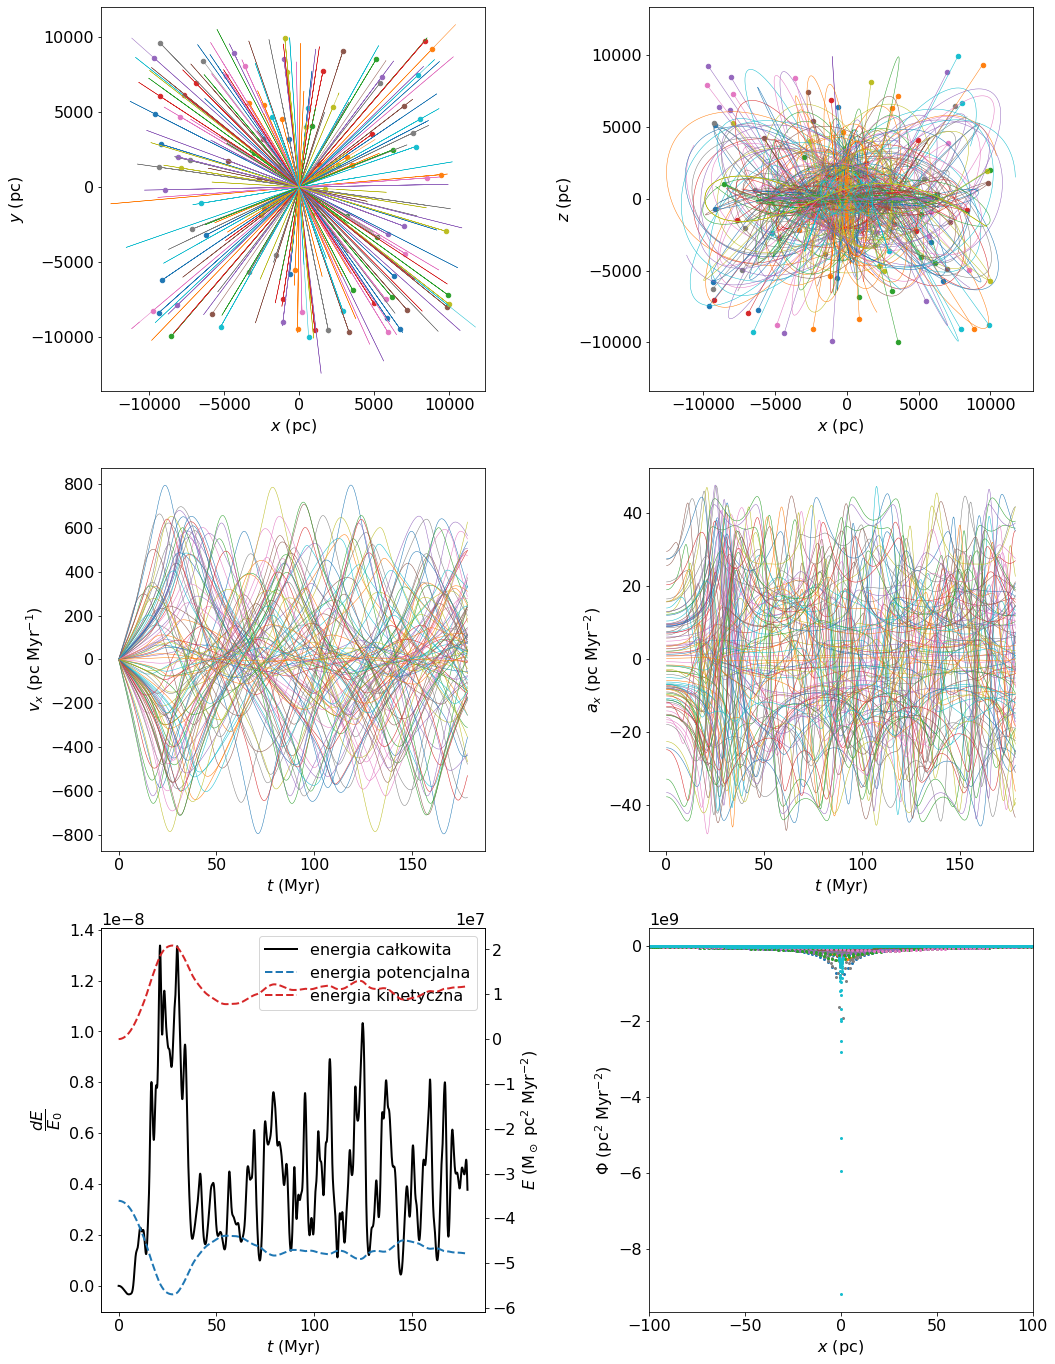

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)
    ax[2,1].plot(r[0][j], -G*M/np.sqrt(r[0][j]**2+r[1][j]**2+r[2][j]**2), ls='', marker='o', markersize=2)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].set_xlabel(r"$x$ (pc)")
ax[2,1].set_ylabel(r"$\Phi$ (pc$^2$ Myr$^{-2}$)")
ax[2,1].set_xlim(-100,100)

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ss3.png", dpi=300, bbox_inches='tight')

# Losowe położenia i prędkości

In [6]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 5*10e+3
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 100
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody+1,nsteps+1))
v = np.zeros((dim,nbody+1,nsteps+1))
a = np.zeros((dim,nbody+1,nsteps+1))
vi = np.zeros((dim,nbody+1))
ai = np.zeros(nbody+1)

r[0,:,0] = random.choices(range(-10000,10000), k=nbody+1)
r[1,:,0] = random.choices(range(-10000,10000), k=nbody+1)
r[2,:,0] = random.choices(range(-10000,10000), k=nbody+1)

# v[0,:,0] = random.choices(range(100,300), k=nbody+1)
# v[1,:,0] = random.choices(range(100,300), k=nbody+1)
# v[2,:,0] = random.choices(range(100,300), k=nbody+1)
v[0,:,0] = random.choices(range(-50,50), k=nbody+1)
v[1,:,0] = random.choices(range(-300,300), k=nbody+1)
v[2,:,0] = random.choices(range(-50,50), k=nbody+1)

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 75.34853889000078 s


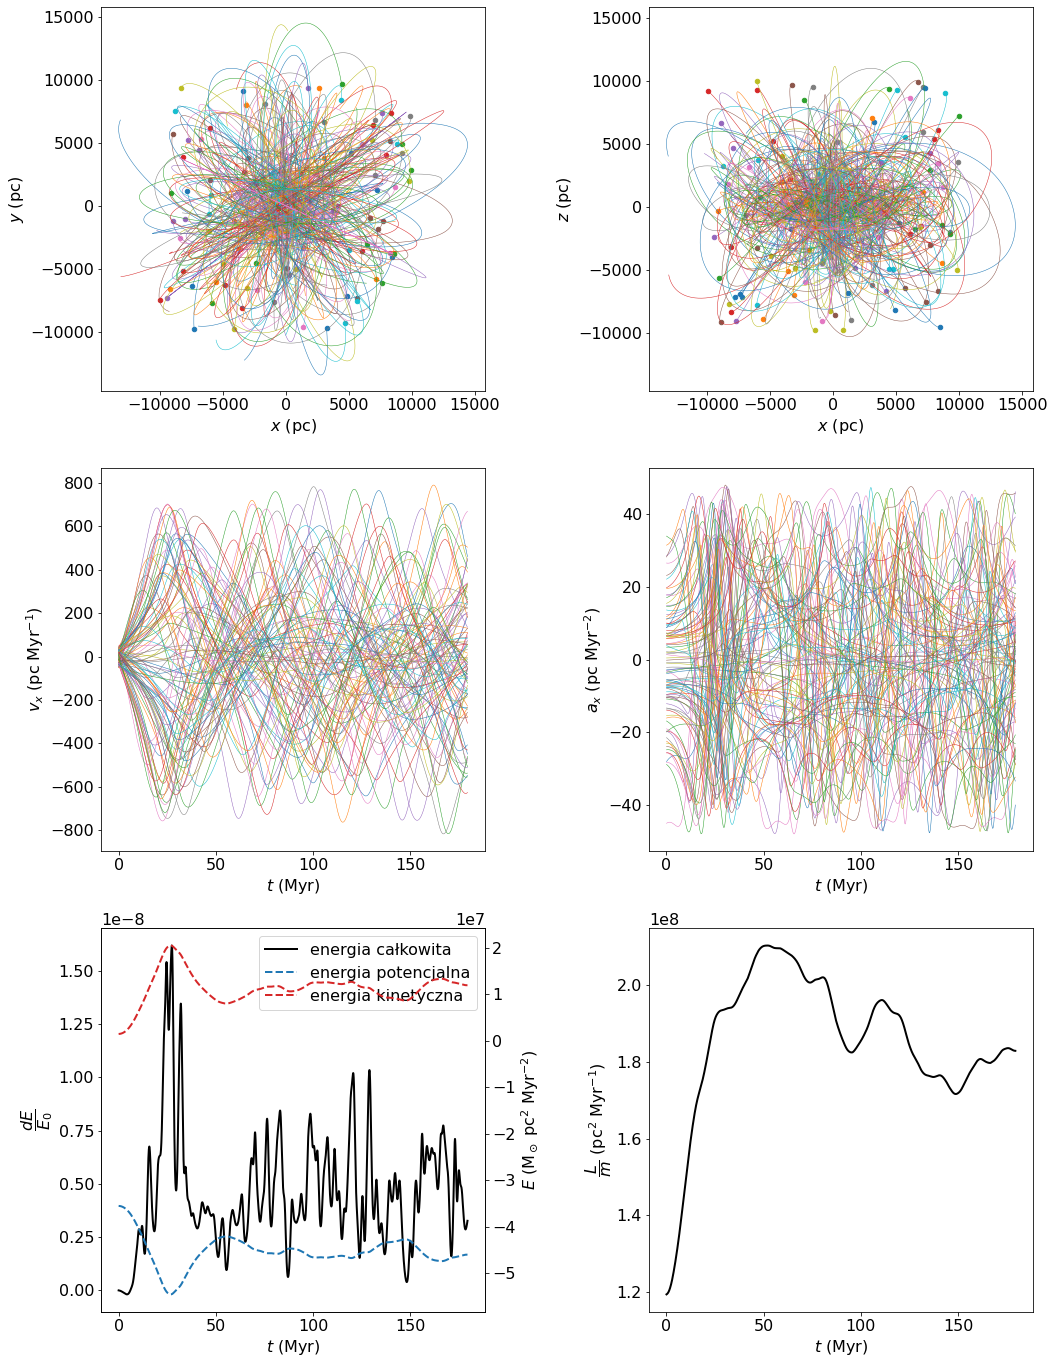

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("lp3.png", dpi=300, bbox_inches='tight')

# Orbity "kołowe"

In [15]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 5*10e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 10
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody+1,nsteps+1))
v = np.zeros((dim,nbody+1,nsteps+1))
a = np.zeros((dim,nbody+1,nsteps+1))
vi = np.zeros((dim,nbody+1))
ai = np.zeros(nbody+1)

r[0,:,0] = random.choices(range(5000,10000), k=nbody+1)

v[1,:,0] = np.sqrt(G*M/np.sqrt(r[0,:,0]**2+r[1,:,0]**2+r[2,:,0]**2))

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 109.67424175999986 s


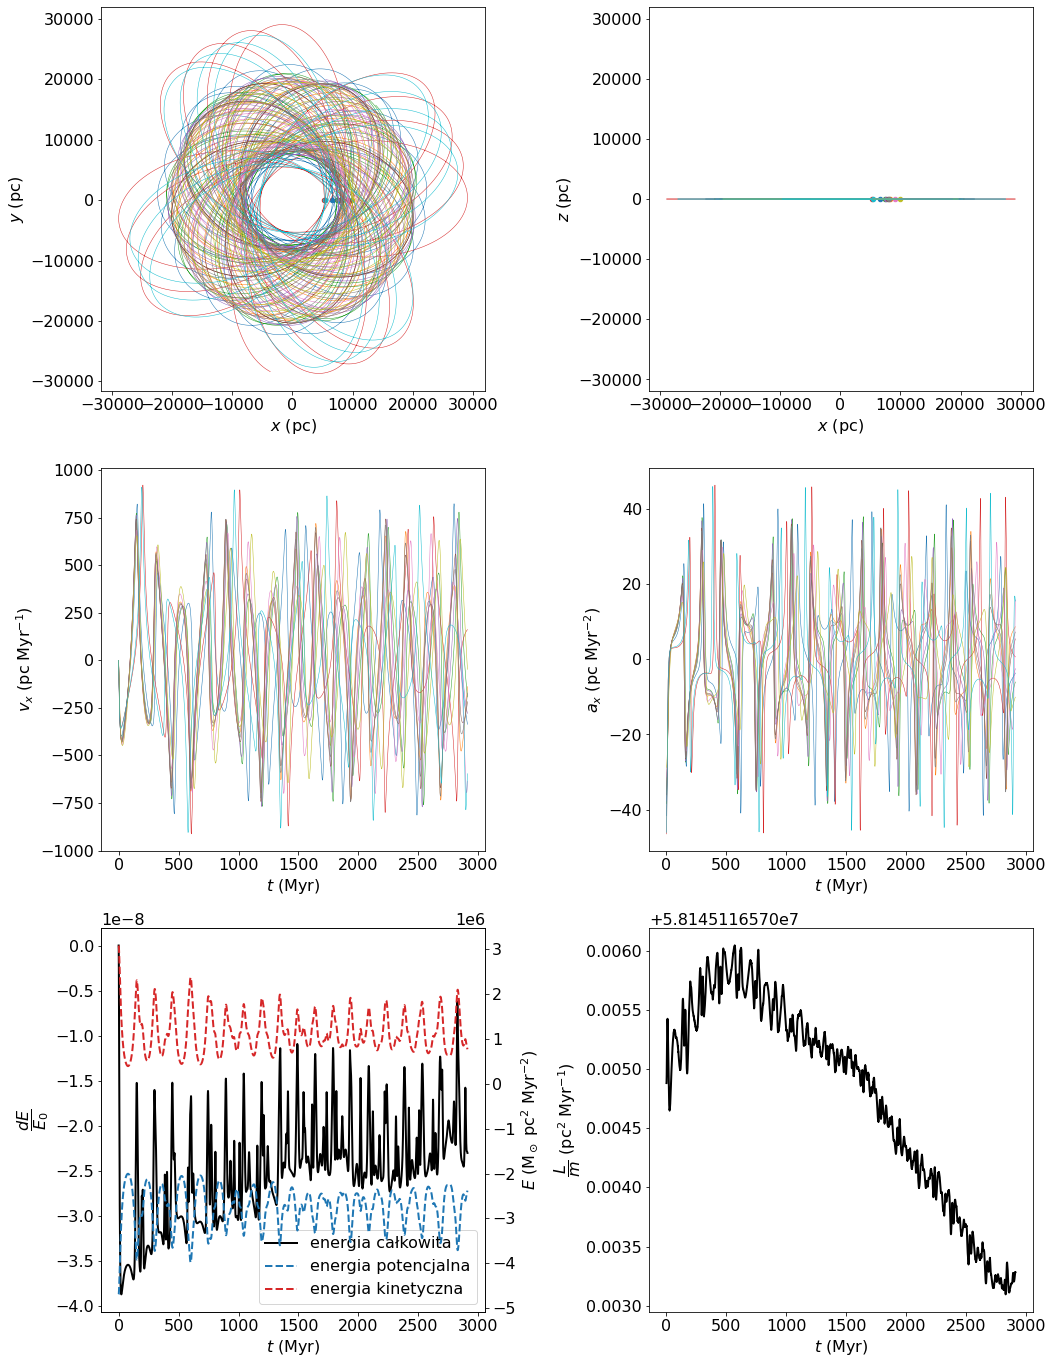

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ok3.png", dpi=300, bbox_inches='tight')

# Orbity "kołowe" + niewielkie zaburzenia

In [17]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 5*10e+4
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 10
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody+1,nsteps+1))
v = np.zeros((dim,nbody+1,nsteps+1))
a = np.zeros((dim,nbody+1,nsteps+1))
vi = np.zeros((dim,nbody+1))
ai = np.zeros(nbody+1)

r[0,:,0] = random.choices(range(5000,10000), k=nbody+1)

v[1,:,0] = np.sqrt(G*M/np.sqrt(r[0,:,0]**2+r[1,:,0]**2+r[2,:,0]**2))+random.choices(range(-50,50), k=nbody+1)

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 111.76229024199893 s


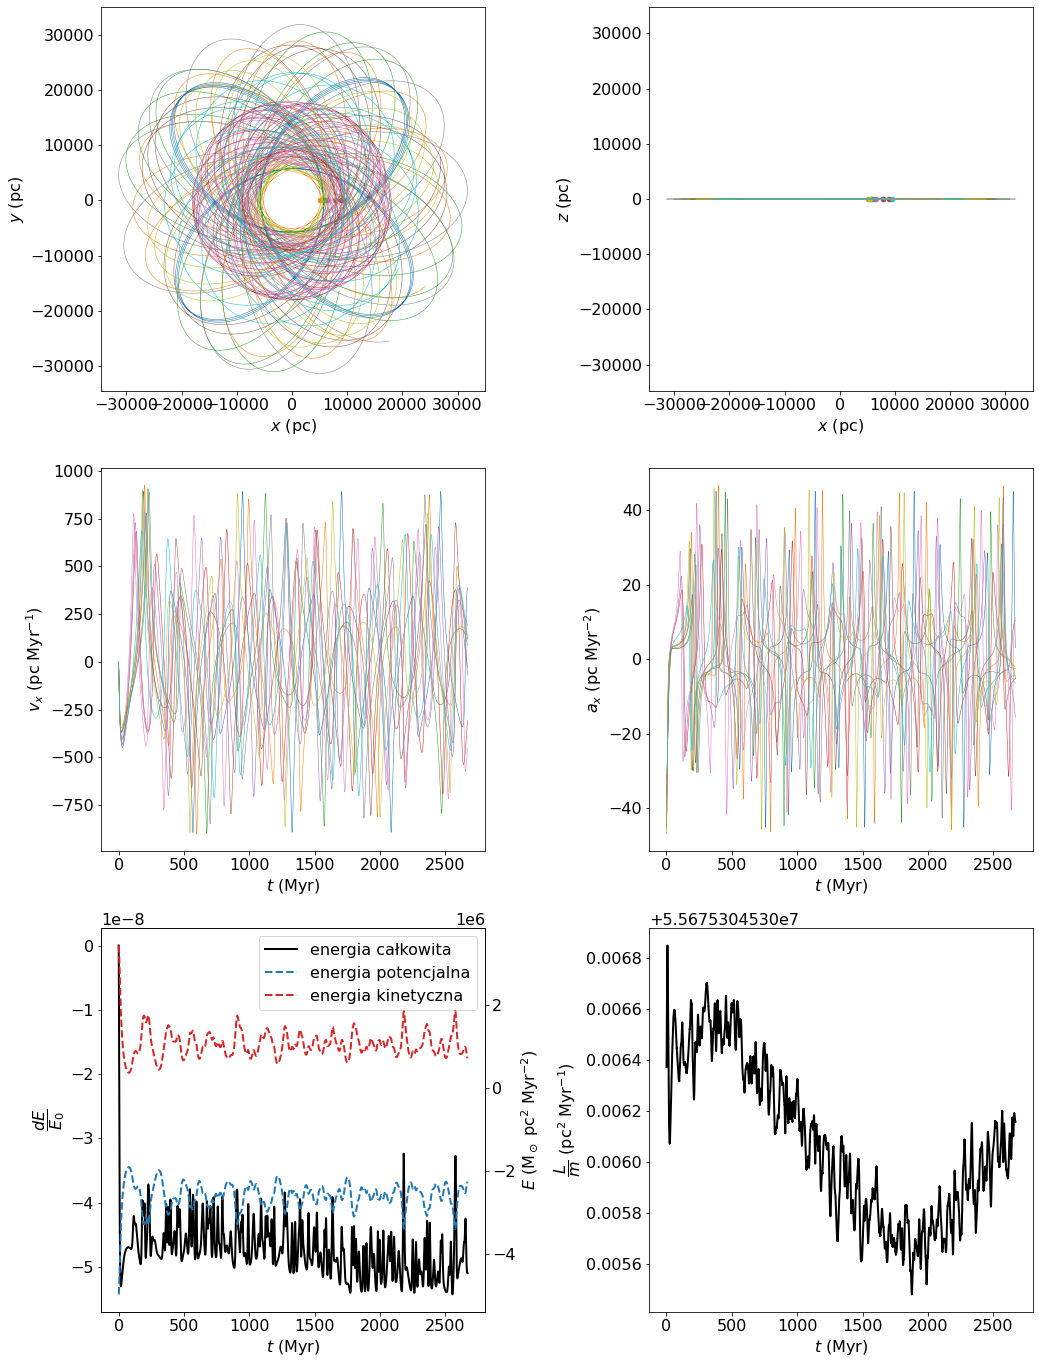

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("okz3.png", dpi=300, bbox_inches='tight')

# Przypadkowe położenia i małe prędkości

In [12]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2
M = 10**12 # M_sun
mi = 1

time = 1e+6
dt = 1 # Myr
nsteps = int(time/dt)

ds = 0.1 # pc
s = 50

eta = 0.05 # pc
epsilon = 0.01


dim = 3
nbody = 2
t = np.zeros(nsteps+1)
en_pot = np.zeros(nsteps+1)
en_kin = np.zeros(nsteps+1)
mom = np.zeros(nsteps+1)
r = np.zeros((dim,nbody+1,nsteps+1))
v = np.zeros((dim,nbody+1,nsteps+1))
a = np.zeros((dim,nbody+1,nsteps+1))
vi = np.zeros((dim,nbody+1))
ai = np.zeros(nbody+1)

r[0,:,0] = random.choices(range(5000,10000), k=nbody+1)
r[1,:,0] = random.choices(range(5000,10000), k=nbody+1)
r[2,:,0] = random.choices(range(5000,10000), k=nbody+1)

v[0,:,0] = random.choices(range(-20,20), k=nbody+1)
v[1,:,0] = random.choices(range(-20,20), k=nbody+1)
v[2,:,0] = random.choices(range(-20,20), k=nbody+1)

start = monotonic()
t, r, v, en_pot, en_kin, mom = KDK(nsteps,r,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

Czas kompilacji: 103.36046155599979 s


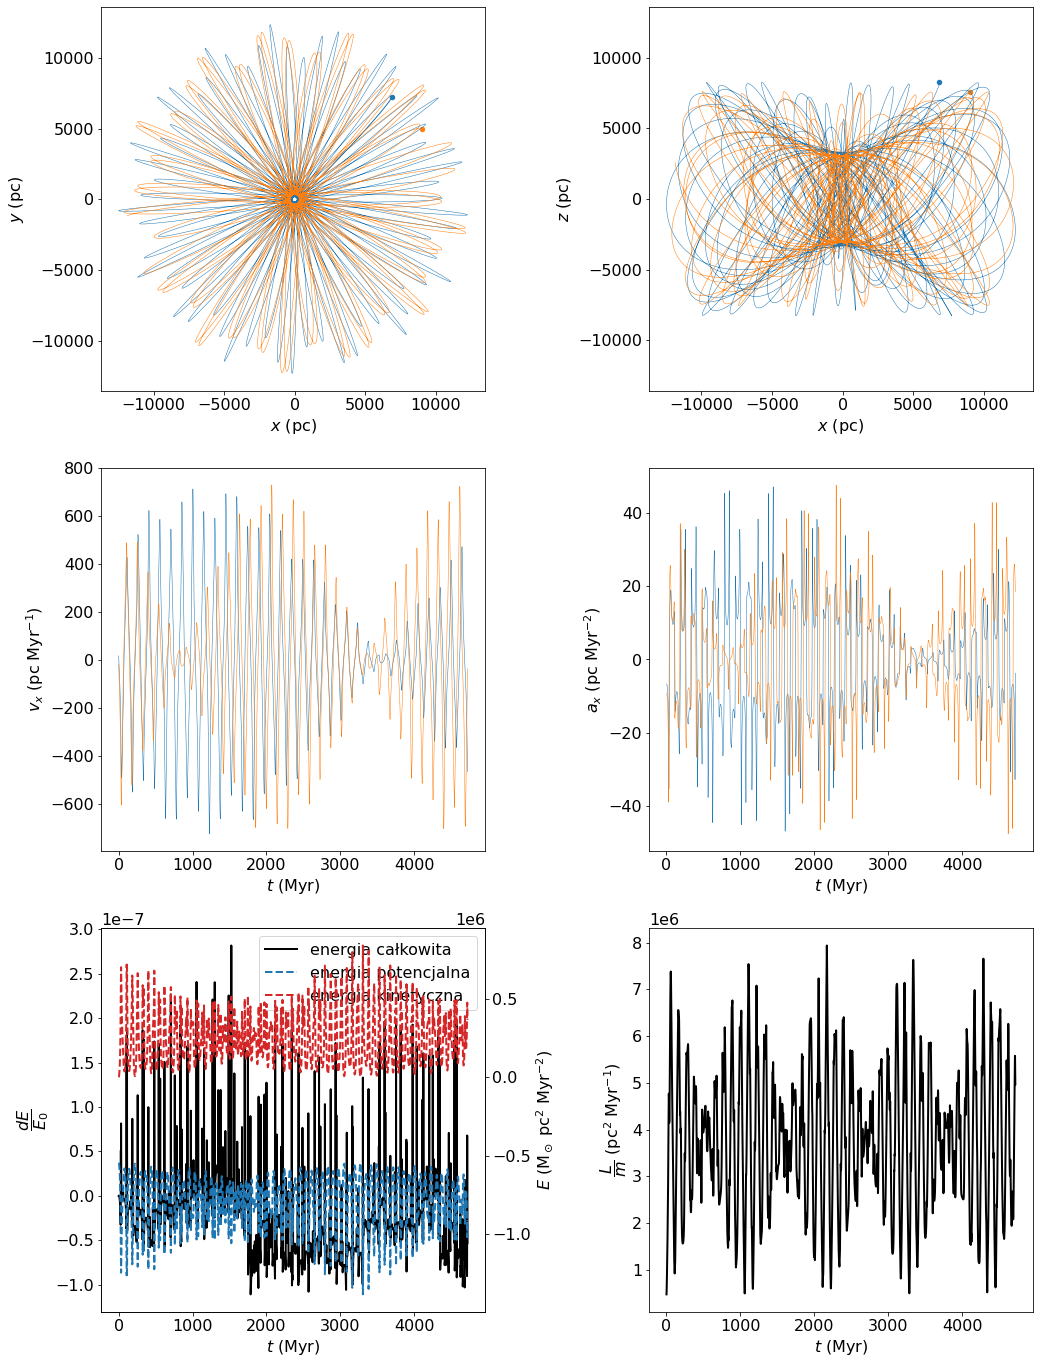

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,24))

for j in range(nbody):
    pl = ax[0,0].scatter(r[0][j][0], r[1][j][0], s=20)
    ax[0,0].plot(r[0][j], r[1][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[0,1].scatter(r[0][j][0], r[2][j][0], s=20, color=pl.get_facecolor()[0])
    ax[0,1].plot(r[0][j], r[2][j], ls='-', lw=0.5, c=pl.get_facecolor()[0])
    ax[1,0].plot(t, v[0][j], ls='-', lw=0.5)
    ax[1,1].plot(t, a[0][j], ls='-', lw=0.5)

tot = ax[2,0].plot(t, (en_pot+en_kin)/(en_pot[0]+en_kin[0])-1, ls='-', lw=2, c='k', label="energia całkowita")

ax2 = ax[2,0].twinx()
pot = ax2.plot(t, en_pot, ls='--', lw=2, c='tab:blue', label="energia potencjalna")
kin = ax2.plot(t, en_kin, ls='--', lw=2, c='tab:red', label="energia kinetyczna")

lns = tot+pot+kin
labs = [l.get_label() for l in lns]
lgnd = ax[2,0].legend(lns, labs, loc="best")

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')

ax[0,0].set_xlabel(r"$x$ (pc)")
ax[0,0].set_ylabel(r"$y$ (pc)")
ax[0,1].set_xlabel(r"$x$ (pc)")
ax[0,1].set_ylabel(r"$z$ (pc)")
ax[1,0].set_xlabel(r"$t$ (Myr)")
ax[1,0].set_ylabel(r"$v_x$ (pc Myr$^{-1}$)")
ax[1,1].set_xlabel(r"$t$ (Myr)")
ax[1,1].set_ylabel(r"$a_x$ (pc Myr$^{-2}$)")
ax[2,0].set_xlabel(r"$t$ (Myr)")
ax[2,0].set_ylabel(r"$\dfrac{dE}{E_0}$")
ax2.set_ylabel(r"$E$ (M$_\odot$ pc$^2$ Myr$^{-2}$)")
ax[2,1].plot(t, mom, ls='-', lw=2, c='k')
ax[2,1].set_xlabel(r"$t$ (Myr)")
ax[2,1].set_ylabel(r"$\dfrac{L}{m}$ (pc$^2$ Myr$^{-1}$)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_box_aspect(1)

plt.savefig("ok3_2.pdf", bbox_inches='tight')

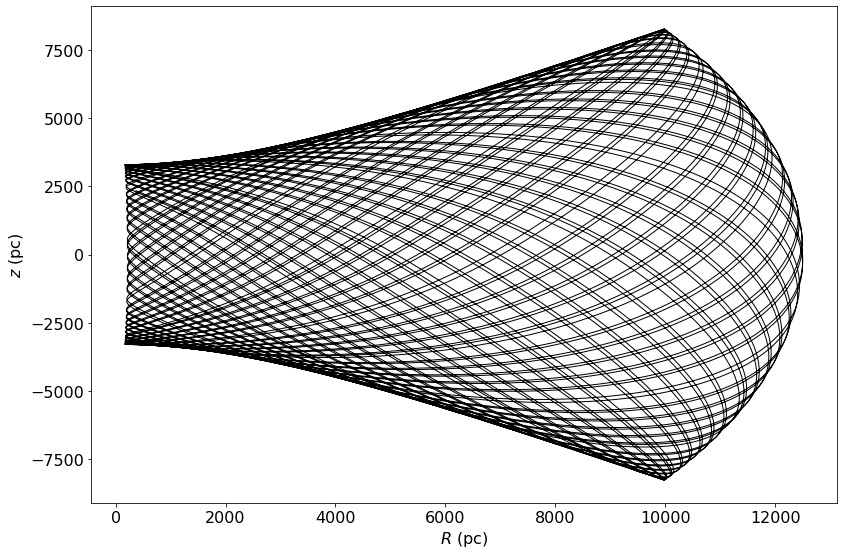

In [14]:
plt.figure(100, tight_layout=True)

for i in range(1):
    plt.plot(np.sqrt(r[0][i]**2+r[1][i]**2), r[2][i], c='k', lw=1)

plt.xlabel(r"$R$ (pc)")
plt.ylabel(r"$z$ (pc)")

plt.savefig("RZ.pdf", bbox_inches='tight')